# All of Softjax

Softjax provides easy-to-use differentiable function surrogates of non-differentiable functions and discrete logic operations in JAX. Softjax offers **soft function surrogates operating on real values, Booleans, and indices** as well as wrappers to use these functions for gradient computation via **straight-through estimation**.

This pages guides you through all of Softjax key functionalities.

In [1]:
from collections.abc import Callable

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D


jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "high")
jax.config.update("jax_platforms", "cpu")


In [2]:
linewidth = 1.0
SMALL_SIZE = 6
MEDIUM_SIZE = 6
BIGGER_SIZE = 6

plt.rcParams["figure.dpi"] = 200
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


def plot(
    fn,
    modes,
    title="",
    softnesses=[3.0, 1.0, 0.2],
    xs=jnp.linspace(-2, 2, 1001),
    **kwargs,
):
    xs = jnp.array(xs)

    colormap = LinearSegmentedColormap.from_list(
        "blue_red", ["dodgerblue", "gold", "lightcoral"]
    )
    # colormap = plt.get_cmap("coolwarm")
    # colormap = plt.get_cmap("Blues")
    colors = colormap(jnp.array(softnesses) / max(softnesses))

    # Create plotting canvas
    fig, axes = plt.subplots(
        2,
        len(modes),
        figsize=(3 * len(modes), 3.5),
        sharex=True,
        sharey="row",
        squeeze=False,
    )

    for col_idx, mode in enumerate(modes):
        ax_f = axes[0][col_idx]
        ax_g = axes[1][col_idx]

        if softnesses:
            for softness, color in zip(softnesses, colors):
                _softness = softness
                ys, grad_vals = jax.vmap(
                    lambda x: jax.value_and_grad(fn)(
                        x, mode=mode, softness=_softness, **kwargs
                    )
                )(xs)
                ax_f.plot(xs, ys, linewidth=linewidth, color=color)
                ax_g.plot(
                    xs,
                    np.array(grad_vals),
                    linewidth=linewidth,
                    color=color,
                )

        ys, grad_vals = jax.vmap(
            lambda x: jax.value_and_grad(fn)(x, mode="hard", softness=None)
        )(xs)
        ax_f.plot(xs, ys, linewidth=linewidth, linestyle="--", color="black")
        ax_g.plot(
            xs,
            grad_vals,
            linewidth=linewidth,
            linestyle="--",
            color="black",
        )

        # ax_f.set_title(f"[{mode}]")
        ax_f.text(
            0.01, 0.99, f"[{mode}]", ha="left", va="top", transform=ax_f.transAxes
        )
        # ax_g.set_title(f"[{mode}]")

        for ax in (ax_f, ax_g):
            # ax.grid(True, linestyle="--", alpha=0.6)
            ax.axhline(0, color="black", linewidth=0.5, alpha=0.7)
            ax.axvline(0, color="black", linewidth=0.5, alpha=0.7)
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.set_xticks([-1.0, 0.0, 1.0])
            ax.margins(x=0)

    # Label axes
    for ax in axes[-1]:
        ax.set_xlabel("x")  # fontsize=14)

    axes[0][0].set_ylabel("function")
    axes[1][0].set_ylabel("gradient")
    axes[0][0].set_yticks([min(min(ys), 0), max(ys)])

    # fig.suptitle(title) #fontsize=20)

    # Build a shared legend for softnesses
    handles = [
        Line2D([0], [0], color=color, lw=1, label=str(s))
        for s, color in zip(softnesses, colors)
    ]
    handles.append(Line2D([0], [0], color="black", lw=1, label=f"{fn.__name__}"))
    handles.reverse()
    fig.legend(
        handles=handles,
        title="softness",
        loc="upper right",
        bbox_to_anchor=(1.0, 0.98),
        ncol=min(len(softnesses) + 1, 6),
        frameon=False,
    )

    # Leave space for the legend and title
    fig.tight_layout(rect=(0, 0, 1, 0.9))
    plt.locator_params(axis="both", nbins=3)
    plt.show()


def plot_value_and_grad(x, values, grads, label_func="function", label_grad="gradient"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    plt.plot(x, values, label=label_func, color="black", linewidth=1.0)
    plt.plot(
        x, grads, label=label_grad, color="dodgerblue", linewidth=1.0, linestyle="--"
    )
    ax.axhline(0, color="black", linewidth=0.5, alpha=0.7)
    ax.axvline(0, color="black", linewidth=0.5, alpha=0.7)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    xmin = round(min(min(x), 0), 1)
    xmax = round(max(x), 1)
    ax.set_xticks([xmin, xmax])
    ax.margins(x=0)
    ax.set_xlabel("x")
    plt.legend()
    plt.xlim(xmin - 0.1, xmax + 0.1)

    fig.tight_layout(rect=(0, 0, 1, 0.9))
    plt.locator_params(axis="both", nbins=3)
    plt.show()


def plot_array(x, plot_text=True, title=""):
    plt.figure(figsize=(4, 2))
    plt.imshow(x, cmap="coolwarm")

    if plot_text:
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                plt.text(
                    j,
                    i,
                    "{:0.2f}".format(x[i, j]),
                    ha="center",
                    va="center",
                    color="white",
                )

    if title:
        plt.title(f"{title}")

    plt.tight_layout
    plt.xticks(range(x.shape[1]))
    plt.yticks(range(x.shape[0]))
    plt.show()


def plot_softindices_1D(x, title=None, log=False):
    # Convert JAX array to numpy array if needed
    if hasattr(x, "__array__"):
        x = np.array(x)

    # Apply log transform if requested
    if log:
        x = np.log(np.maximum(x, 1e-10))  # Add small epsilon to avoid log(0)

    my_cmap = plt.get_cmap("coolwarm")

    # Rescale function that handles constant arrays
    def rescale(arr):
        arr = np.array(arr)
        arr_min = np.min(arr)
        arr_max = np.max(arr)
        if arr_max - arr_min < 1e-10:  # All values are the same
            return np.zeros_like(arr)  # Return zeros (will map to middle of colormap)
        return (arr - arr_min) / (arr_max - arr_min)

    fig, ax = plt.subplots(1, 1, figsize=(4, 1))
    colors = my_cmap(rescale(x))
    ax.bar(range(x.shape[0]), x, color=colors)
    ax.set_xticks(range(x.shape[0]))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("indices")  # fontsize=14)
    ax.set_yticks([round(min(min(x), 0), 1), round(max(x), 1)])
    if title:
        ax.set_title(f"{title}")
    plt.tight_layout()
    plt.show()


def plot_softbool_operation(fn, title=""):
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)

    # F = -X * Y - Y - X
    F = fn(X, Y)
    plt.figure(figsize=(5, 4))
    cf = plt.contourf(X, Y, F, levels=50, cmap="coolwarm")
    levels = np.arange(0, 1, 0.1)
    c = plt.contour(X, Y, F, colors="k", levels=levels, linewidths=0.5)
    plt.clabel(c, inline=True, fontsize=8)
    plt.colorbar(cf)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(label=f"{fn.__name__}")
    # plt.xticks(np.arange(0,1,0.2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect("equal", "box")
    plt.tight_layout()
    plt.show()


def plot_value_grad_2D(
    fn: Callable,
    min_val=-1,
    max_val=1,
    title="",
):
    x = jnp.linspace(min_val, max_val, 100)
    y = jnp.linspace(min_val, max_val, 100)
    X, Y = jnp.meshgrid(x, y)
    F = fn(X, Y)
    # Compute the gradient field on the grid so we can quiver-plot it
    grad_fn = jax.grad(lambda a, b: fn(a, b), argnums=(0, 1))
    grad_over_row = jax.vmap(
        lambda x_row, y_row: jax.vmap(lambda _x, _y: grad_fn(_x, _y))(x_row, y_row)
    )
    grad_x, grad_y = grad_over_row(X, Y)

    # normalize the gradient vectors for better visualization
    grad_magnitude = jnp.sqrt(grad_x**2 + grad_y**2)
    grad_x = jnp.where(grad_magnitude > 0, grad_x / grad_magnitude, 0)
    grad_y = jnp.where(grad_magnitude > 0, grad_y / grad_magnitude, 0)

    plt.figure(figsize=(5, 4))
    cf = plt.contourf(np.array(X), np.array(Y), np.array(F), levels=50, cmap="coolwarm")

    stride = max(1, X.shape[0] // 20)  # thin the arrows to keep the plot readable
    plt.quiver(
        np.array(X[::stride, ::stride]),
        np.array(Y[::stride, ::stride]),
        np.array(grad_x[::stride, ::stride]),
        np.array(grad_y[::stride, ::stride]),
        color="white",
        alpha=0.9,
        linewidth=0.5,
        scale=50,
    )

    plt.colorbar(cf)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(label=title or f"{fn.__name__}")
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.gca().set_aspect("equal", "box")
    plt.tight_layout()
    plt.show()

## 1. Softening
Many functions are not particulary well suited for gradient-based optimization as their gradients are either zero or undefined at discontinuities. Therefore, a typical approach in machine learning is to use soft surrogates for these functions to enable gradient-based optimization via automatic differentiation. Softjax provides such soft surrogates for many operations in JAX.

As shown below, Softjax provides two hyper-parameters to tune soft function surrogates:

- **mode** being the type of function used for obtaining a soft approximation. 

- **softness** defining how close the surrogate function approximates the original function.


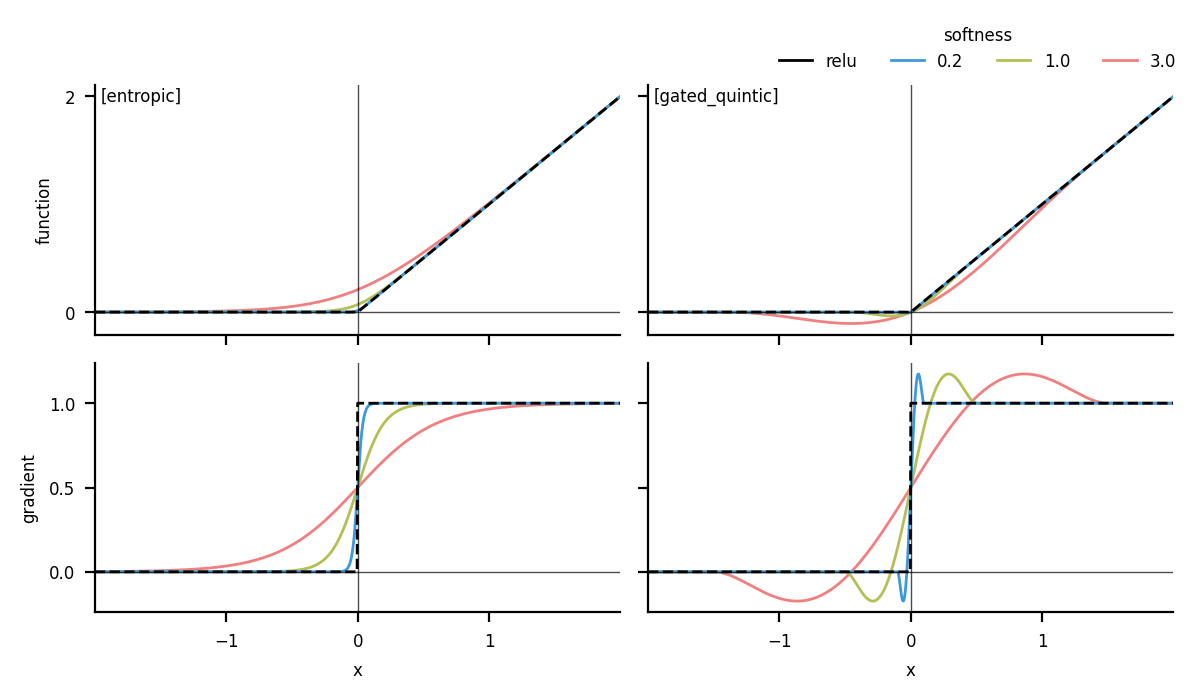

In [3]:
import softjax as sj

plot(sj.relu, modes=["entropic", "gated_quintic"])

SoftJAX provides function surrogates for many other function such as the **absolute function**.

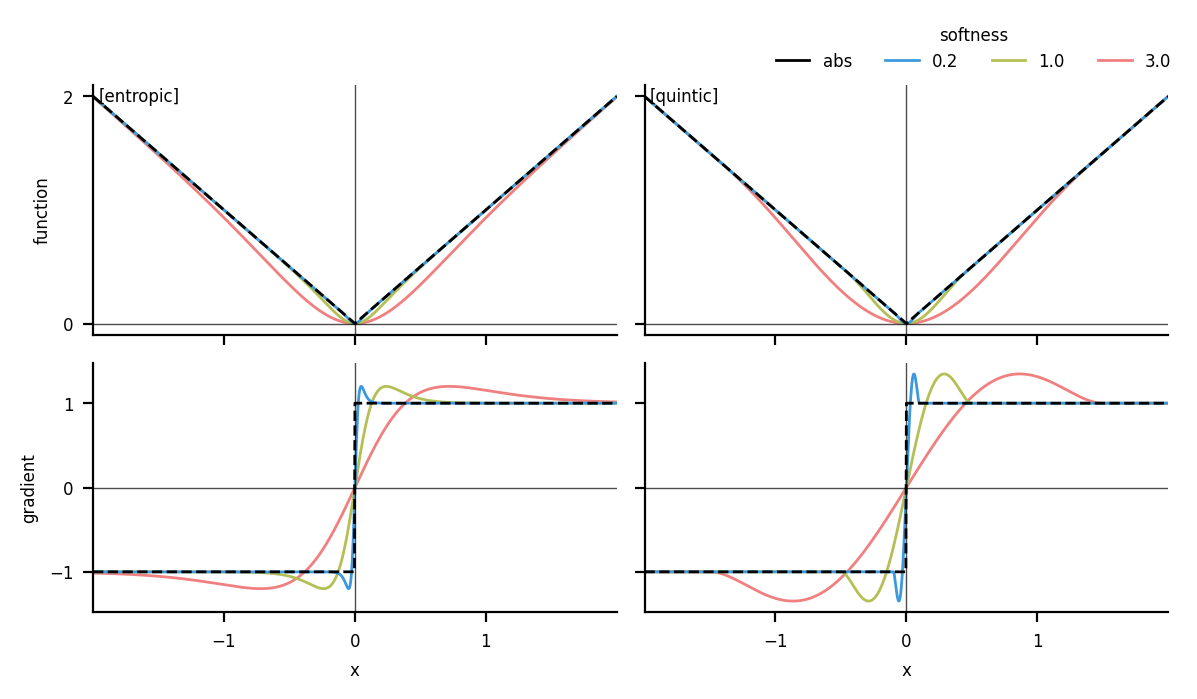

In [4]:
plot(sj.abs, modes=["entropic", "quintic"])

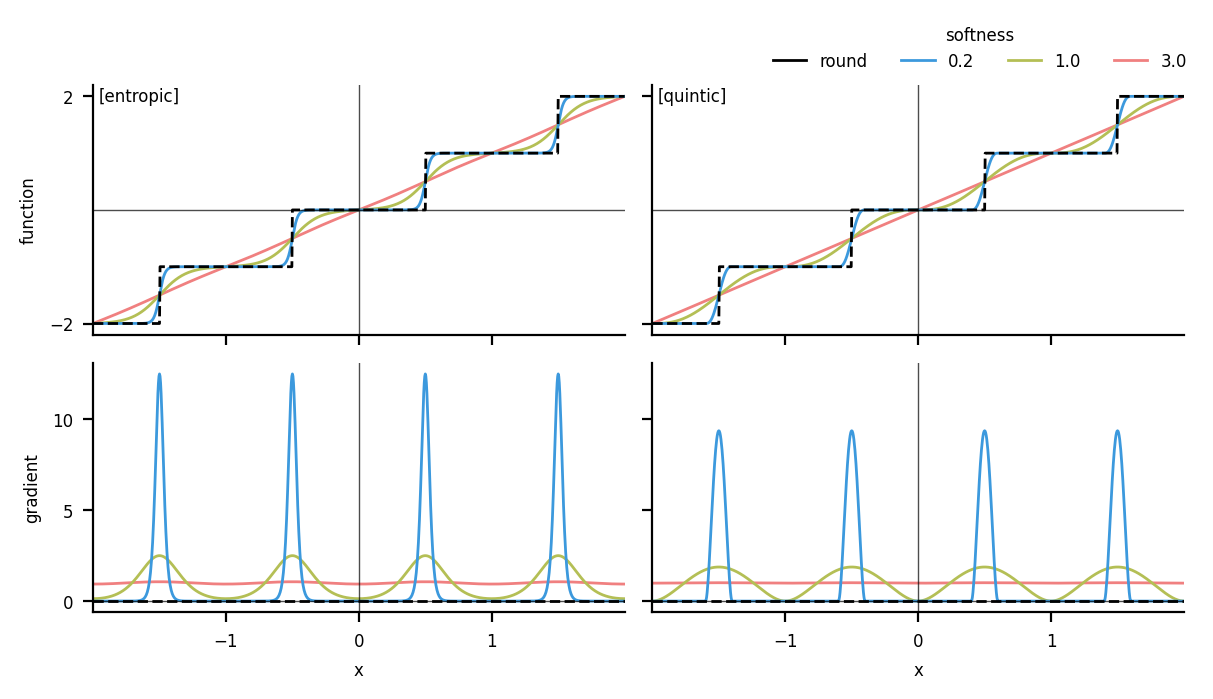

In [5]:
plot(sj.round, modes=["entropic", "quintic"])

## 2. Straight-through estimation
Soft function surrogates can be used to compute *soft gradients* (or more accurately: *soft vector-jacobian-producs*) without modifying the forward pass via [straight-through estimation](https://docs.jax.dev/en/latest/advanced-autodiff.html#straight-through-estimator-using-stop-gradient). Straight-through estimation uses JAX's [automatic differentiation system](https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html) to replace only the function's gradient with the gradient of the surrogate function.


> **Note:** Historically, straight-through estimators refer to the special case of treating a function as the [identity operation on the backward pass](https://arxiv.org/pdf/1308.3432). We use the term more generally to describe the case of replacing a function with smooth a surrogate on the backward pass.


> **Example - ReLu activation:** The [rectified linear unit](https://en.wikipedia.org/wiki/Rectified_linear_unit) (aka `relu`)  is commonly used as activation function in neural networks. For $x<0$ the gradient of the `relu` is zero. In turn, neural networks containing `relu` activations may suffer from the ["dying ReLu problem"](https://arxiv.org/abs/1903.06733) where the gradients computed via automatic differentiation become zero when a gradient-based optimizer adjusts the inputs of ReLU functions to $x<0$.
As pointed out in ["The Resurrection of the ReLU"](https://arxiv.org/pdf/2505.22074), you can mitigate these problems by replacing its backward pass with a soft surrogate function. To do this with Softjax, simply replace the `relu` activation in your code with `sj.st(sj.relu)`, or equivalently directly use our wrapped primitives via `sj.relu_st` for convenience.


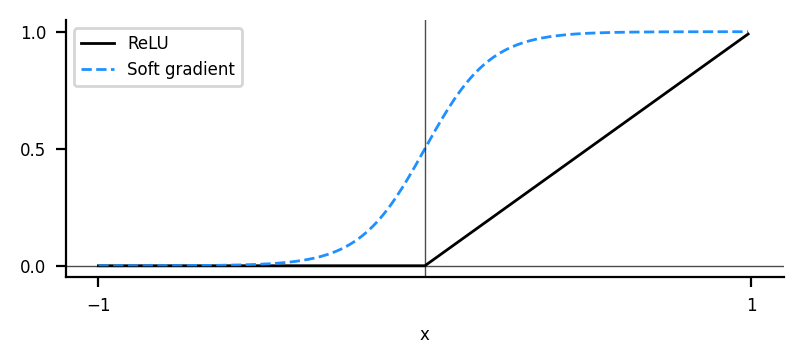

In [6]:
soft_relu = sj.st(sj.relu)

x = jnp.arange(-1, 1, 0.01)
values, grads = jax.vmap(jax.value_and_grad(soft_relu))(x)
plot_value_and_grad(x, values, grads, label_func="ReLU", label_grad="Soft gradient")


### The STE Trick
Under the hood `sj.st()` uses the [stop-gradient](https://docs.jax.dev/en/latest/advanced-autodiff.html#straight-through-estimator-using-stop-gradient) oepration to replace the gradient of a function.

```python
def st(fn: Callable) -> Callable:
    sig = inspect.signature(fn)
    mode_default = sig.parameters.get("mode").default
    def wrapped(*args, **kwargs):
        mode = kwargs.pop("mode", mode_default)
        fw_y = fn(*args, **kwargs, mode="hard")
        bw_y = fn(*args, **kwargs, mode=mode)
        return jtu.tree_map(lambda fw, bw: jax.lax.stop_gradient(fw - bw) + bw, fw_y, bw_y)
    return wrapped
```

By adding and subtracting the backward function `bw_y` to the function call, it does not alter the function's forward pass `fw_y`. Due to `jax.lax.stop_gradient`, only the *soft* backward function `bw_y` is used in the gradient computation.



### Custom differentiation rules
The `@sj.st` decorator can also be used to define custom straight-through operations. 
This can be useful when combining multiple functions provided by the softjax library. For this, it is important to understand, that simply applying the straight-through trick to every non-smooth function does not always result in the intended behavior.
Consider for example the case of multiplying the output of two `relu` functions together. This function only provides meaningful gradients in the first quadrant, we would like to change it such that we get a meaningful signal in the whole domain, as visualized below.

Note: We normalize the plotted gradient vectors for reduced cluttering.

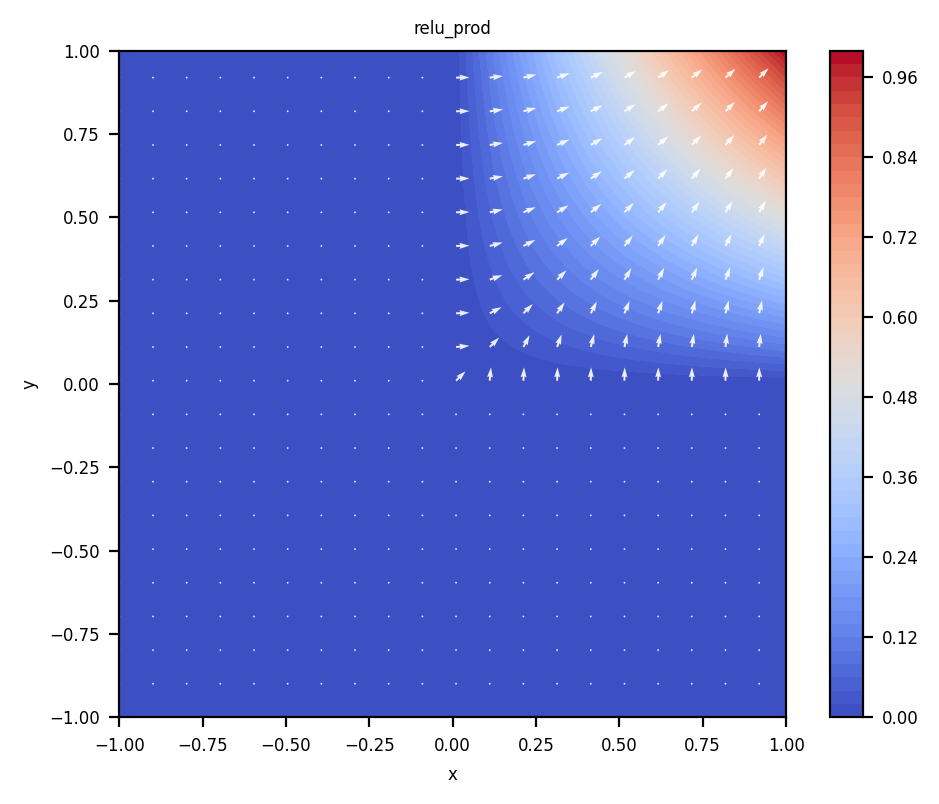

In [7]:
def relu_prod(x, y):
    # Standard ReLU product, no softening
    return jax.nn.relu(x) * jax.nn.relu(y)


plot_value_grad_2D(relu_prod)

A naive approach would be to replace each relu with `sj.relu_st` independently. However, the resulting function will not provide informative gradients for every input.
This is due to the chain rule, in which the gradient flowing through one relu is multiplid by the (forward) output of the other relu. As the forward pass is not smoothed, the gradient will sometimes be multiplied by zero, resulting in no informative gradient.

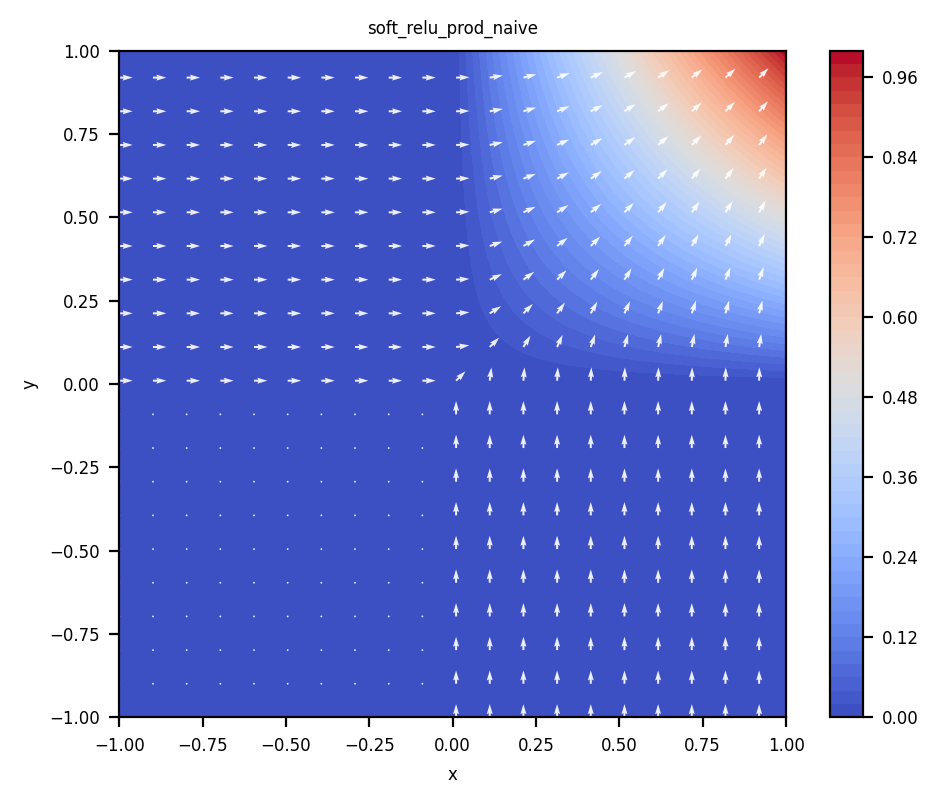

In [8]:
def soft_relu_prod_naive(x, y, mode="entropic", softness=1.0):
    # Naive straight-through implementation
    return sj.relu_st(x, mode=mode, softness=softness) * sj.relu_st(
        y, mode=mode, softness=softness
    )


plot_value_grad_2D(soft_relu_prod_naive)

An alternative approach for softening this function is to apply the straight through trick on the **outer level** as illustrated below.
When applied on the outer level, the forward pass computes the hard product of ReLUs as before, whereas the backward pass differentiates through the product of smooth relus.

Notice that we use sj.relu instead of sj.relu_st here.

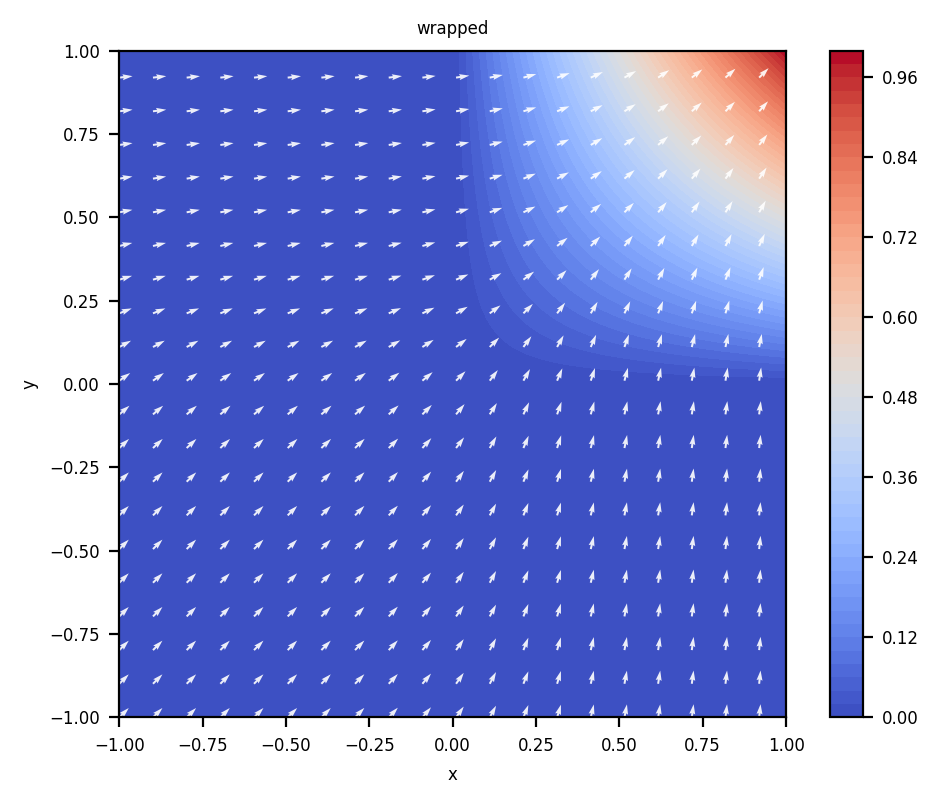

In [9]:
@sj.st
def soft_relu_prod_custom_st(x, y, mode="entropic", softness=1.0):
    # Custom straight-through implementation
    return sj.relu(x, mode=mode, softness=softness) * sj.relu(
        y, mode=mode, softness=softness
    )


plot_value_grad_2D(soft_relu_prod_custom_st)

We observe that as expected, this version of the function now also produces informative gradients in the third quadrant.
In the simple above example, the only both `sj.relu` functions take the same parameters, therefore it was easy to just apply the `sj.st` decorator again.

In general, we might want to define custom behavior. This can be implemented by using the `@sj.grad_replace` decorator, which allows custom control flow conditioned on a `forward` boolean variable. The function will then execute with `forward=True` on the forward pass and `forward=False` on the backward pass.

```python
def grad_replace(fn: Callable) -> Callable:
    def wrapped(*args, **kwargs):
        fw_y = fn(*args, **kwargs, forward=True)
        bw_y = fn(*args, **kwargs, forward=False)
        return jtu.tree_map(lambda fw, bw: jax.lax.stop_gradient(fw - bw) + bw, fw_y, bw_y)
    return wrapped
```

## 3. Soft bools
Softjax provides differentiable surrogates of JAX's Boolean operators. A Boolean (aka Bool) is a data type that takes one of two possible values either being `false` or `true` (aka 0 or 1). Many operations in JAX such as `greater` or `isclose` generate arrays containing Booleans, while other operations such as `logical_and` or `any` operate on such arrays. 

> **Example - `jax.numpy.greater` yields zero gradients:** As shown below, `jax.grad` does not raise an error when called on its boolean operations. However, the returned gradients are zero for all array entries.

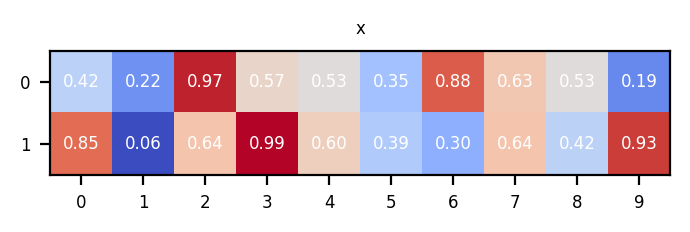

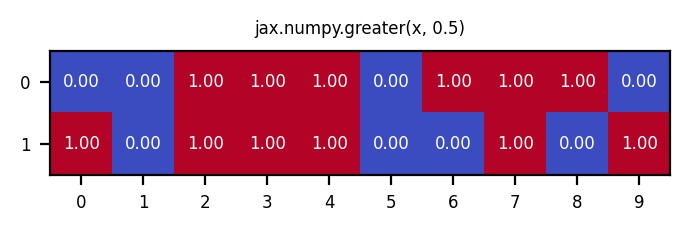

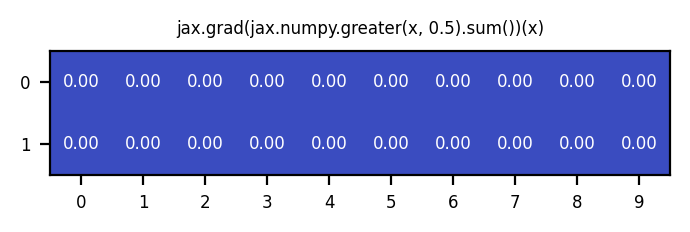

In [10]:
x = jax.random.uniform(jax.random.key(0), shape=(2, 10))
bool_array = jax.numpy.greater(x, 0.5)


def boolean_loss(x):
    return jax.numpy.greater(x, 0.5).sum().astype("float32")


boolean_grads = jax.grad(boolean_loss)(x)

plot_array(x, title="x")
plot_array(bool_array, title="jax.numpy.greater(x, 0.5)")
plot_array(boolean_grads, title="jax.grad(jax.numpy.greater(x, 0.5).sum())(x)")

> **Example - `softjax.greater_st` yields useful gradients:** Instead of `jax.numpy.greater`, let's use `softjax.greater_st` (straight_through variant of `softjax.greater`). As shown below, thanks to straight-through estimation, `softjax.greater_st` yields exact Booleans while the gradient of the Boolean loss points in informative directions.

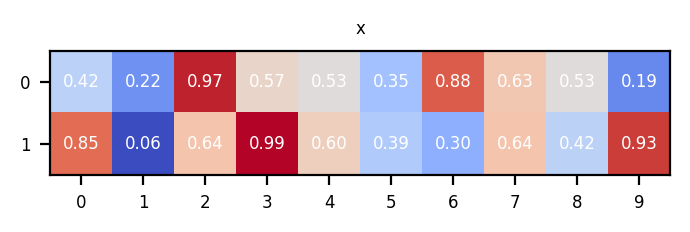

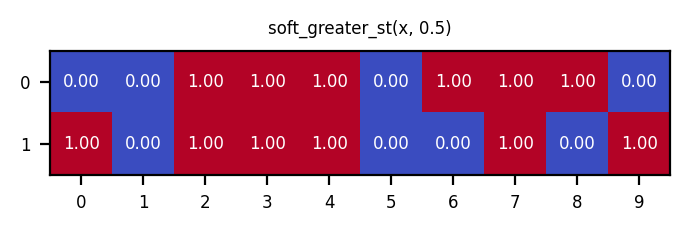

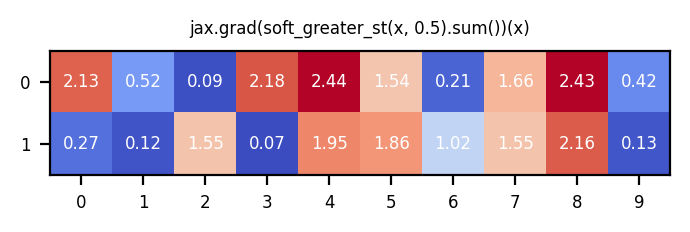

In [11]:
def soft_boolean_loss(x):
    return sj.greater_st(x, 0.5).sum()


x = jax.random.uniform(jax.random.key(0), shape=(2, 10))
bool_array = sj.greater_st(x, 0.5)
boolean_grads = jax.grad(soft_boolean_loss)(x)

plot_array(x, title="x")
plot_array(bool_array, title="soft_greater_st(x, 0.5)")
plot_array(boolean_grads, title="jax.grad(soft_greater_st(x, 0.5).sum())(x)")

### Generating soft bools
How does Softjax make Boolean logic operations differentiable? A real number $x\in \mathbb{R}$ could be mapped to a `Bool` using the Heaviside function
$$
H(x) = \begin{cases}
1, & x > 0 \\
0.5, & x=0\\
0, & x < 0
\end{cases}.
$$
The gradient of the Heaviside function (as implemented in JAX) is zero everywhere and hence unsuited for differentiable optimization. Instead of operating directly on Booleans, Softjax's differentiable logic operators resort to *soft Booleans*. A soft Boolean aka `SoftBool` can be interpreted as the probability of a Boolean being `True`.

We replace the heaviside function with differentiable surrogate such as the sigmoid function $\sigma(x) = \frac{1}{1+e^{-x}}$. While the `sigmoid` is the canonical example for mapping a real number to a `SoftBool`, Softjax provides additional surrogates.

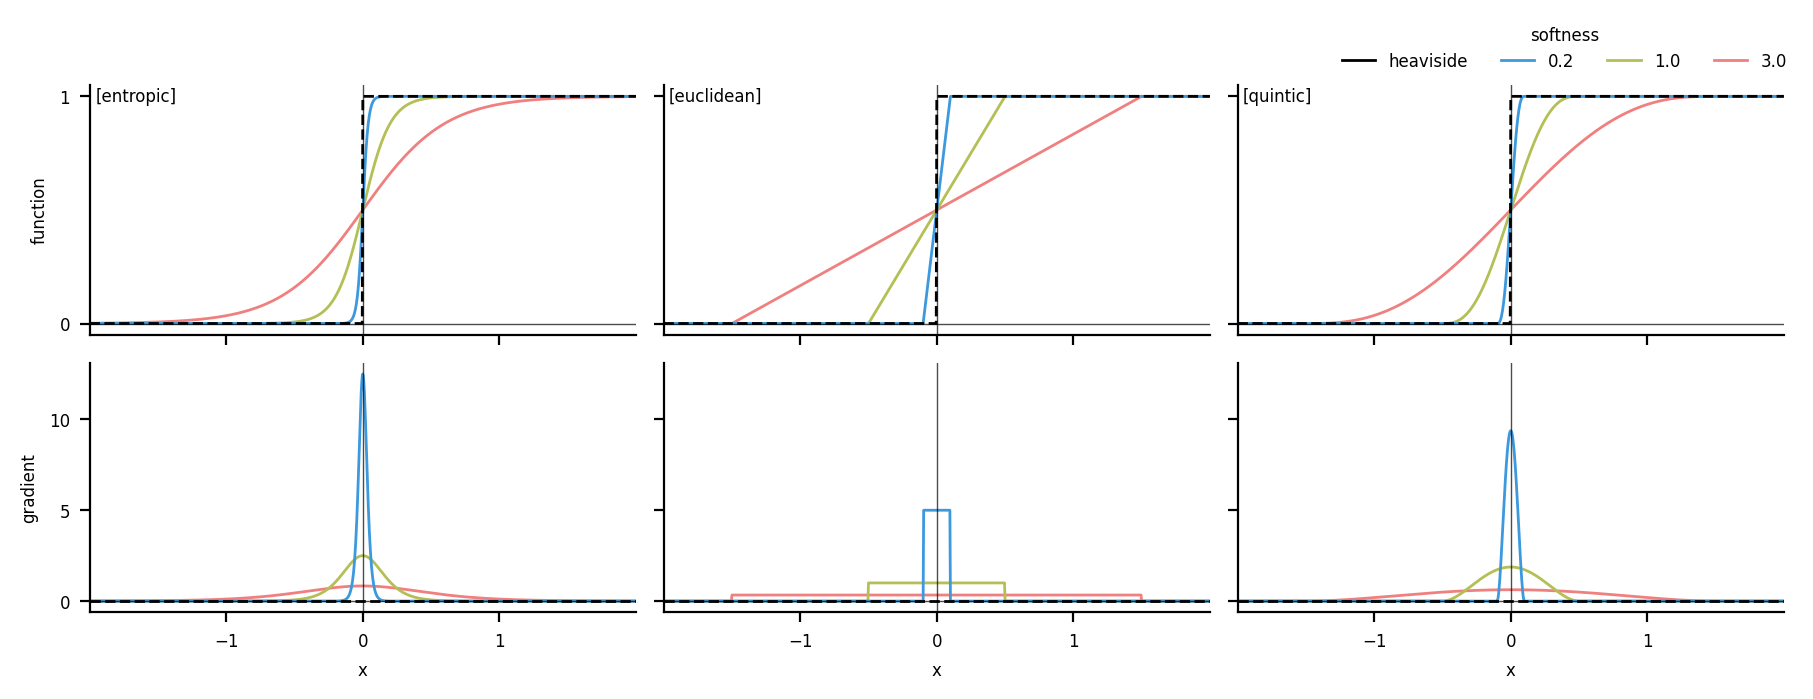

In [12]:
plot(sj.heaviside, modes=["entropic", "euclidean", "quintic"])

In the above case, the `linear` and `quintic` relaxations have the advantage of altering the original function only in a bounded region, a property that can be desireble in some cases.

Given the concept of a `SoftBool`, a probabilistic surrogate for binary logical operations such as `jax.numpy.equal` and `jax.numpy.greater` is obtained by simply shifting the sigmoid.

> **Example - Greater operator:** `sj.greater(x,y)` corresponds to shifting `sj.heaviside` by `y` to the right. The output can be interpreted as the probability $P(x \geq y)\in[0,1]$ with $x\in\mathbb{R}$ and $y\in\mathbb{R}$.

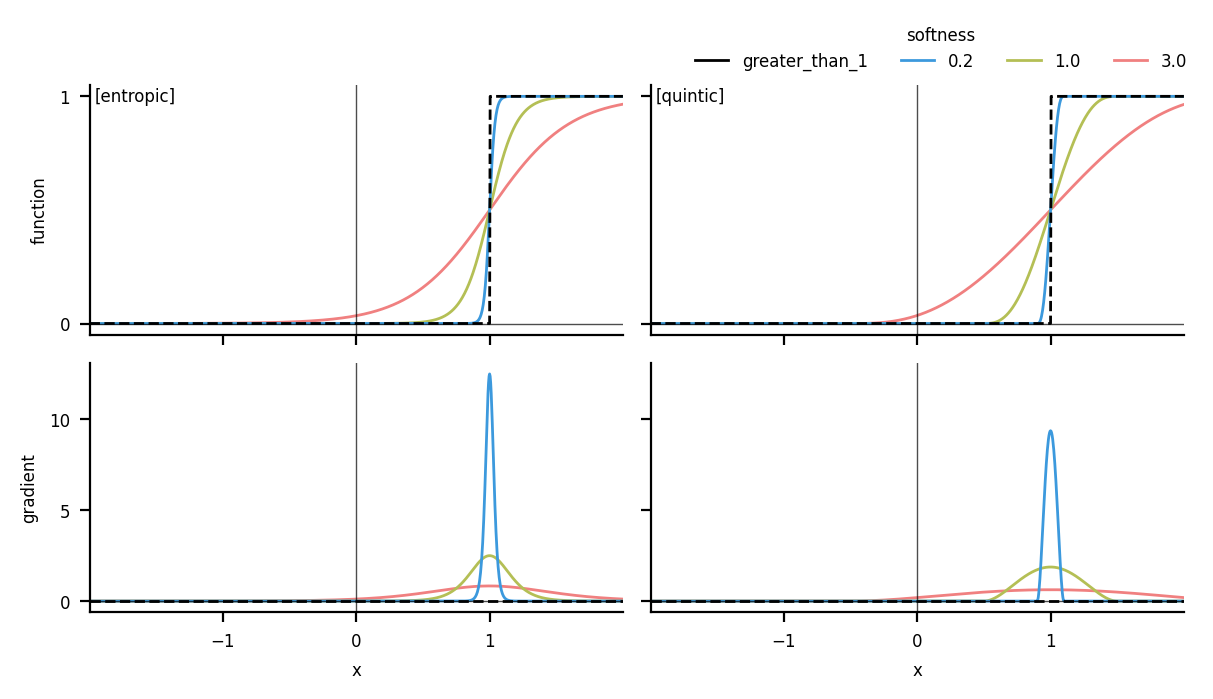

In [13]:
def greater_than_1(x, mode="entropic", softness=1.0):
    return sj.greater(x, y=jnp.array(1.0), mode=mode, softness=softness)


plot(greater_than_1, modes=["entropic", "quintic"])


### Manipulating soft bools
Softjax replaces a Boolean with a `SoftBool`, in turn Boolean logic operators are replaced in Softjax with [fuzzy logic](https://en.wikipedia.org/wiki/Fuzzy_logic) operators that effectively compute the probabilities of Boolean events.

> **Example - Logical NOT:** Given a `SoftBool` $P(B)$ (being the probability that a Boolean event $B$ occurs), the probability of the event not occuring is $P(\bar B) = 1 - P(B)$ as implemented in `sj.logical_not`.
```python
def logical_not(x: SoftBool) -> SoftBool:
    return 1 - x
```
Given `sj.logical_not`, the probability that `x is not greater equal 0.5` is given by `sj.logical_not(sj.greater_st(x, 0.5))`. Due to the straight-through trick, the function `sj.logical_not(sj.greater_st(x, 0.5))` uses exact Boolean logic in the forward pass and the `SoftBool` probability computation in the backward pass.

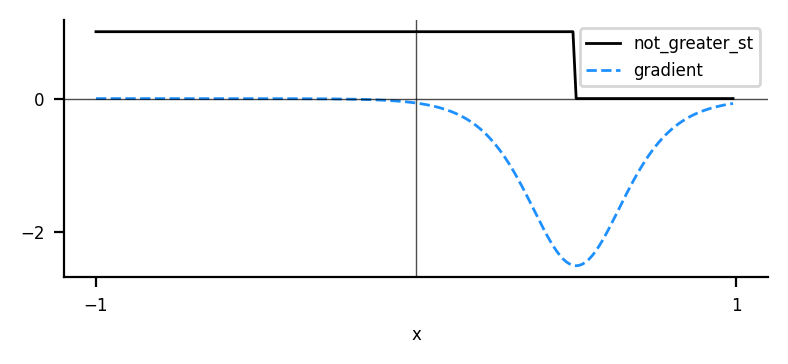

In [14]:
def not_greater_st(x):
    return sj.logical_not(sj.greater_st(x, y=0.5, mode="entropic", softness=1.0))


x = jnp.arange(-1, 1, 0.01)
values, grads = jax.vmap(jax.value_and_grad(not_greater_st))(x)
plot_value_and_grad(x, values, grads, label_func="not_greater_st")

> **Example - Logical AND:** Given two `SoftBools` $P(A)$ and $P(B)$, the probability that both independent events occur is $P(A \wedge B) = P(A) \cdot P(B)$.
```python
def logical_and(x: SoftBool, y: SoftBool) -> SoftBool:
    return x * y
```

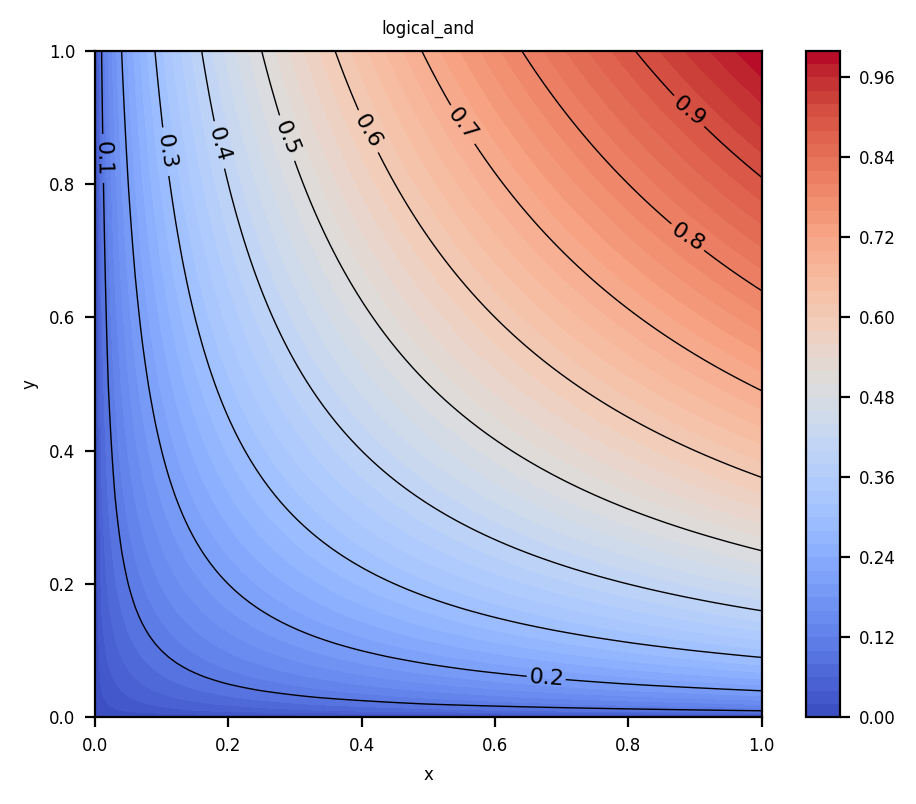

In [15]:
plot_softbool_operation(sj.logical_and)

**Example - Logical XOR:** Softjax computes other soft logic operators such as `sj.logical_xor` by combining `sj.logical_not` and `sj.logical_and`.
```python
def sj.logical_xor(x: SoftBool, y: SoftBool) -> SoftBool:
    return logical_or(logical_and(x, logical_not(y)), logical_and(logical_not(x), y))
```

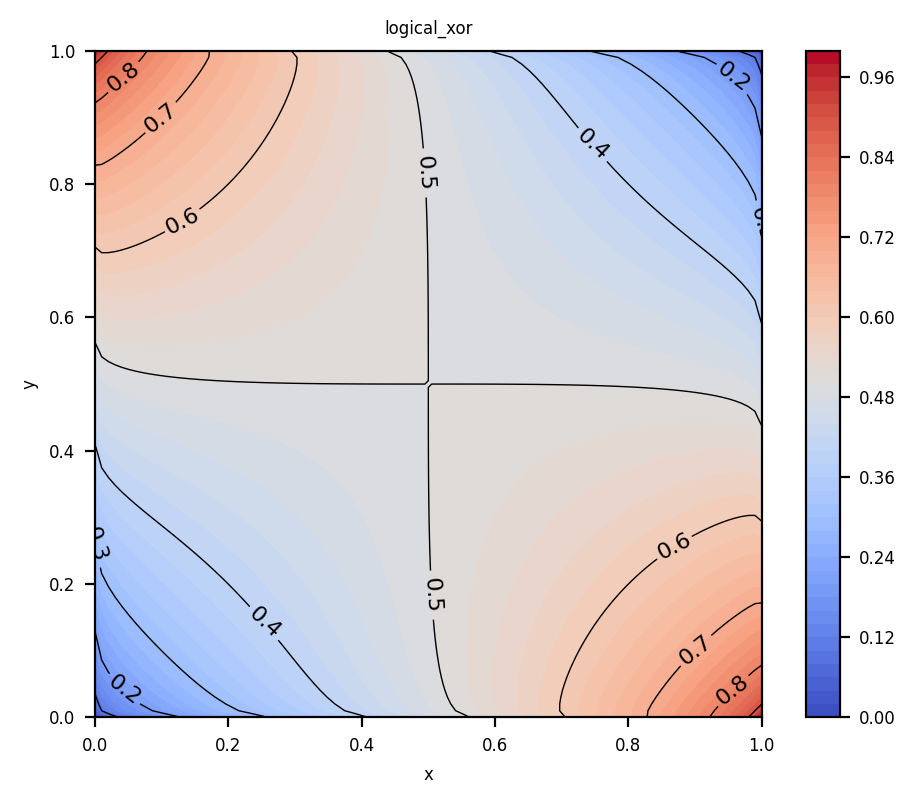

In [16]:
plot_softbool_operation(sj.logical_xor)

### Selection with soft bools
Through the use of Fuzzy logic operators, Softjax provides a toolbox to make many non-differentiable functions of JAX differentiable.

> **Example - sj.where():** The function `jax.numpy.where(condition, x, y)` selects elements of array `x` if `condition == True` and otherwise selects `y`. Softjax provides a differentiable surrogate for this function via `sj.where(P, x, y)` which effectively computes the expected value $\mathbb{E}[X] = P \cdot x + (1-P) \cdot y$.

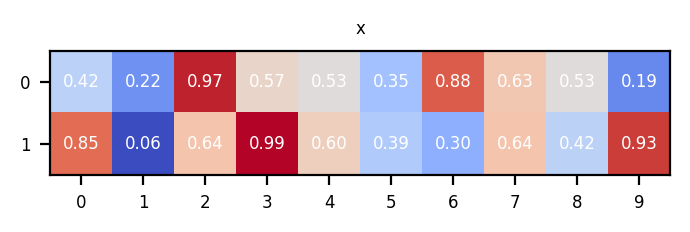

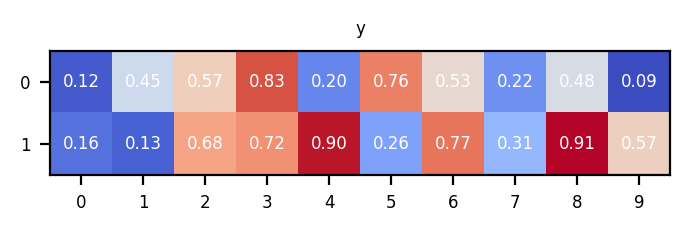

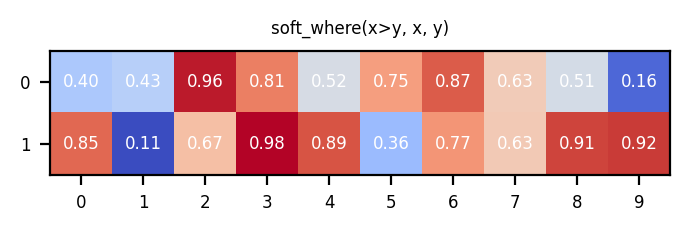

In [17]:
greater = lambda x, y: sj.greater(x, y, mode="entropic", softness=1.0)
soft_where = lambda x, y: sj.where(greater(x, y), x, y)

x = jax.random.uniform(jax.random.key(0), shape=(2, 10))
y = jax.random.uniform(jax.random.key(1), shape=(2, 10))

plot_array(x, title="x")
plot_array(y, title="y")
plot_array(soft_where(x, y), title="soft_where(x>y, x, y)")

## 4. Soft indices
Softjax offers soft surrogates for functions that generate **indices as outputs**, such as `argmax`, `argmin`, `argtop_k`, `argmedian`, and `argsort`.
The main mechanism here is to replace hard indices with distributions over indices (`SoftIndex`), allowing for informative gradients.

Similar to how `SoftBool` required going from boolean logic to fuzzy logic, this now requires adjusting functions that do selection via indices. As such, we provide new versions of e.g. `take_along_axis`, `dynamic_index_in_dim`, and `choose`.
Combining the soft index generation with the selection then allows to define surrogates for the corresponding `max`, `min`, `top_k`, `median` and `sort` functions.

### Generating soft indices
In JAX, functions like `jax.argmax` return integer indices as outputs, which can take values within {0, ..., len(x)-1}.

In [18]:
x = jnp.array([1, 2, 3])
print(jnp.argmax(x))

2


In comparison, SoftJAX computes a `SoftIndex` array. Each entry of a `SoftIndex` array contains the probability that the index is being selected.

In [19]:
x = jnp.array([1, 2, 3])
print(sj.argmax(x))

[2.06106005e-09 4.53978686e-05 9.99954600e-01]


> **Example - Softmax:** The "softmax" (or more precisely "softargmax") is a commonly used  differentiable surrogate for the `argmax` function (it is also the default softening mode in `sj.argmax`). The $\text{softmax}(x) = \frac{\exp(x_i)}{\sum_j\exp(x_j)}$ returns a discrete probability distribution over indices (aka a `SoftIndex`). As shown in the plots below, the softmax is fully differentiable. It is commonly used for multi-class classification and in transformer networks.

When `softness` is low, `sj.argmax` concentrates probability on the true maximum index (e.g., `[1.0, 0.0, 0.0]`), recovering the hard maximum. When `softness` is higher, the result smoothly interpolates between values, providing useful gradients for optimization.

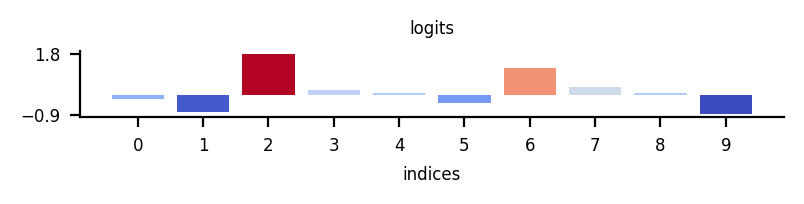

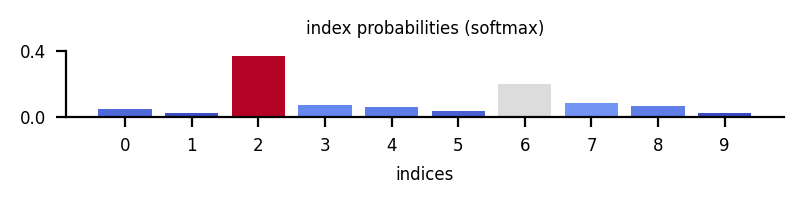

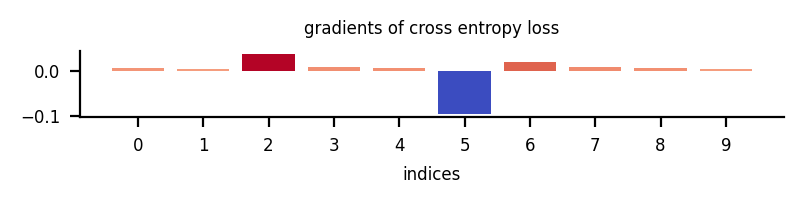

In [20]:
def cross_entropy(x, class_target=5):
    probs = sj.argmax(x, softness=10.0)
    target_one_hot = jax.nn.one_hot(class_target, num_classes=x.shape[0])
    log_probs = jnp.log(probs)
    return -(target_one_hot * log_probs).mean()


x = jax.random.normal(jax.random.key(0), shape=(10,))
probs = sj.argmax(x, softness=10.0)
lossgrads = jax.grad(cross_entropy)(x)

plot_softindices_1D(x, title="logits")
plot_softindices_1D(probs, title="index probabilities (softmax)")
plot_softindices_1D(lossgrads, title="gradients of cross entropy loss")

Note that while in a conventional array of indices, the index information is stored in the integer values, a `SoftIndex` stores the probabilities over possible indices in an extra dimension. By convention, **we always put this additional dimension into the final axis**. Except for this additional final dimension, the shape of the returned soft index matches that of the indices returned by standard JAX.
Here are a few examples of this:

In [21]:
x = jnp.arange(12).reshape((3, 4))
print("x.shape:", x.shape)
print("jnp.argmax(x, axis=1).shape:", jnp.argmax(x, axis=1).shape)
print("sj.argmax(x, axis=1).shape:", sj.argmax(x, axis=1).shape)
print("jnp.argmax(x, axis=0).shape:", jnp.argmax(x, axis=0).shape)
print("sj.argmax(x, axis=0).shape:", sj.argmax(x, axis=0).shape)
print(
    "jnp.argmax(x, axis=1, keepdims=True).shape:",
    jnp.argmax(x, axis=1, keepdims=True).shape,
)
print(
    "sj.argmax(x, axis=1, keepdims=True).shape:",
    sj.argmax(x, axis=1, keepdims=True).shape,
)
print(
    "jnp.argmax(x, axis=0, keepdims=True).shape:",
    jnp.argmax(x, axis=0, keepdims=True).shape,
)
print(
    "sj.argmax(x, axis=0, keepdims=True).shape:",
    sj.argmax(x, axis=0, keepdims=True).shape,
)

x.shape: (3, 4)
jnp.argmax(x, axis=1).shape: (3,)
sj.argmax(x, axis=1).shape: (3, 4)
jnp.argmax(x, axis=0).shape: (4,)
sj.argmax(x, axis=0).shape: (4, 3)
jnp.argmax(x, axis=1, keepdims=True).shape: (3, 1)
sj.argmax(x, axis=1, keepdims=True).shape: (3, 1, 4)
jnp.argmax(x, axis=0, keepdims=True).shape: (1, 4)
sj.argmax(x, axis=0, keepdims=True).shape: (1, 4, 3)


We also offer soft versions of `argmedian`, `argtop_k` and `argsort`.


In [22]:
x = jax.random.uniform(jax.random.key(0), shape=(4,))
print("x:", x)
print("jnp.argmedian(x):\n", "Not implemented in standard JAX")
print("sj.argmedian(x):\n", sj.argmedian(x))

print("jax.lax.top_k(x, k=3)[1]:\n", jax.lax.top_k(x, k=3)[1])
print("sj.argtop_k(x, k=3):\n", sj.argtop_k(x, k=3))

print("jnp.argsort(x):\n", jnp.argsort(x))
print("sj.argsort(x):\n", sj.argsort(x))

x: [0.41845711 0.21629545 0.96532146 0.57450053]
jnp.argmedian(x):
 Not implemented in standard JAX
sj.argmedian(x):
 [4.95553956e-01 8.69234800e-03 1.99739291e-04 4.95553956e-01]
jax.lax.top_k(x, k=3)[1]:
 [2 3 0]
sj.argtop_k(x, k=3):
 [[4.11469085e-03 5.44954558e-04 9.75750772e-01 1.95895826e-02]
 [1.66975269e-01 2.21144035e-02 1.59597616e-02 7.94950566e-01]
 [7.42554231e-01 9.83447670e-02 3.13131302e-03 1.55969689e-01]]
jnp.argsort(x):
 [1 0 3 2]
sj.argsort(x):
 [[1.14092958e-01 8.61461280e-01 4.81124140e-04 2.39646378e-02]
 [7.42554231e-01 9.83447670e-02 3.13131302e-03 1.55969689e-01]
 [1.66975269e-01 2.21144035e-02 1.59597616e-02 7.94950566e-01]
 [4.11469085e-03 5.44954558e-04 9.75750772e-01 1.95895826e-02]]


Again, the shape of the returned `SoftIndex` matches that of the normal index array, except for an additional dimension in the last axis that matches the size of the input array along the specified axis. A few examples:

In [23]:
x = jax.random.uniform(jax.random.key(0), shape=(3, 4))
print("x.shape:", x.shape)
# standard JAX only added support for axis argument in jax.lax.top_k recently, normally uses last axis
print("jax.lax.top_k(x, k=2, axis=1)[1].shape:", jax.lax.top_k(x, k=2)[1].shape)
print("sj.argtop_k(x, k=2, axis=1).shape:", sj.argtop_k(x, k=2, axis=1).shape)
print("sj.argtop_k(x, k=2, axis=0).shape:", sj.argtop_k(x, k=2, axis=0).shape)
print("jnp.argsort(x, axis=1).shape:", jnp.argsort(x, axis=1).shape)
print("sj.argsort(x, axis=1).shape:", sj.argsort(x, axis=1).shape)
print("jnp.argsort(x, axis=0).shape:", jnp.argsort(x, axis=0).shape)
print("sj.argsort(x, axis=0).shape:", sj.argsort(x, axis=0).shape)
# standard JAX does not support argmedian
print("sj.argmedian(x, axis=1).shape:", sj.argmedian(x, axis=1).shape)
print("sj.argmedian(x, axis=0).shape:", sj.argmedian(x, axis=0).shape)
print(
    "sj.argmedian(x, axis=1, keepdims=True).shape:",
    sj.argmedian(x, axis=1, keepdims=True).shape,
)
print(
    "sj.argmedian(x, axis=0, keepdims=True).shape:",
    sj.argmedian(x, axis=0, keepdims=True).shape,
)

x.shape: (3, 4)
jax.lax.top_k(x, k=2, axis=1)[1].shape: (3, 2)
sj.argtop_k(x, k=2, axis=1).shape: (3, 2, 4)
sj.argtop_k(x, k=2, axis=0).shape: (2, 3, 4)
jnp.argsort(x, axis=1).shape: (3, 4)
sj.argsort(x, axis=1).shape: (3, 4, 4)
jnp.argsort(x, axis=0).shape: (3, 4)
sj.argsort(x, axis=0).shape: (3, 4, 3)
sj.argmedian(x, axis=1).shape: (3, 4)
sj.argmedian(x, axis=0).shape: (4, 3)
sj.argmedian(x, axis=1, keepdims=True).shape: (3, 1, 4)
sj.argmedian(x, axis=0, keepdims=True).shape: (1, 4, 3)


Note: All of the functions in this section come with the three modes: `hard`, `entropic` and `euclidean`.
`hard` mode produces one-hot soft indices and is mainly used in straight-through estimation. `entropic` is the recommended soft default and reduces all operations to either a softmax or an entropy-regularized optimal transport problem.
Finally, `euclidean` reduces operations to L2 projection onto the unit simplex or the Birkhoff polytope, which can be used to produce sparse outputs. See the API documentation for details.

### Selection with SoftIndices

Given a `SoftIndex`, Softjax provides (differentiable) helper functions for selecting array elements, mirroring the non-differentiable indexing in standard JAX. Put simply, entries of an array are selected by computing the expected value:

$$\mathrm{E}(arr, p) = \sum_{i} arr[i] \cdot p[i] = arr^{\top} \cdot p$$

where $p$ is the `SoftIndex`.


> **Example `sj.take_along_axis`:** The function `sj.take_along_axis` is central to this selection mechanism. It generalizes `jnp.take_along_axis` to work with probability distributions (SoftIndices) instead of just integer indices.

The standard `jnp.take_along_axis(arr, indices, axis)` selects elements from `arr` using integer indices. Conceptually, it works by:
1. Slicing along the specified axis to get 1D arrays
2. Using the corresponding indices to select elements
3. Assembling the results into the output array

One of its main uses is to accept the index output of e.g. `jnp.argmax` and [select the maximum values at the indexed locations](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.take_along_axis.html).
While `jnp.take_along_axis` uses integer indices `out_1d[j] = arr_1d[indices_1d[j]]`, `sj.take_along_axis` accepts a `SoftIndex` to compute the corresponding the weighted sum: `out_1d[j] = sum_i(arr_1d[i] * soft_indices_2d[j, i])`.

In [24]:
x = jax.random.uniform(jax.random.key(0), shape=(2, 3))
print("x:\n", x)

indices = jnp.argmin(x, axis=1, keepdims=True)
print("min_jnp:\n", jnp.take_along_axis(x, indices, axis=1))

indices_onehot = sj.argmin(x, axis=1, mode="hard", keepdims=True)
print("min_sj_hard:\n", sj.take_along_axis(x, indices_onehot, axis=1))

indices_soft = sj.argmin(x, axis=1, keepdims=True)
print("min_sj_soft:\n", sj.take_along_axis(x, indices_soft, axis=1))

x:
 [[0.41845711 0.21629545 0.96532146]
 [0.57450053 0.53222649 0.35490518]]
min_jnp:
 [[0.21629545]
 [0.35490518]]
min_sj_hard:
 [[0.21629545]
 [0.35490518]]
min_sj_soft:
 [[0.24029622]
 [0.39747788]]


As a convenience, this combination of `sj.take_along_axis` with `SoftIndex`-generataing functions is already implemented ino Softjax's `max`, `median`, `top_k` and `sort` functions.

In [25]:
x = jax.random.uniform(jax.random.key(0), shape=(4,))
print("x:", x)

print("jnp.max(x):", jnp.max(x))
print("sj.max(x, mode='hard'):", sj.max(x, mode="hard"))
print("sj.max(x):", sj.max(x))

print("jnp.median(x):", jnp.median(x))
print("sj.median(x, mode='hard'):", sj.median(x, mode="hard"))
print("sj.median(x):", sj.median(x))

print("jax.lax.top_k(x, k=2)[0]:", jax.lax.top_k(x, k=2)[0])
print("sj.top_k(x, k=2, mode='hard')[0]:", sj.top_k(x, k=2, mode="hard")[0])
print("sj.top_k(x, k=2)[0]:", sj.top_k(x, k=2)[0])

print("jnp.sort(x):", jnp.sort(x))
print("sj.sort(x, mode='hard'):", sj.sort(x, mode="hard"))
print("sj.sort(x):", sj.sort(x))

x: [0.41845711 0.21629545 0.96532146 0.57450053]
jnp.max(x): 0.9653214611189975
sj.max(x, mode='hard'): 0.9653214611189975
sj.max(x): 0.9550070794223621
jnp.median(x): 0.49647882272194555
sj.median(x, mode='hard'): 0.49647882272194555
sj.median(x): 0.494137017678798
jax.lax.top_k(x, k=2)[0]: [0.96532146 0.57450053]
sj.top_k(x, k=2, mode='hard')[0]: [0.96532146 0.57450053]
sj.top_k(x, k=2)[0]: [0.95500708 0.54676106]
jnp.sort(x): [0.21629545 0.41845711 0.57450053 0.96532146]
sj.sort(x, mode='hard'): [0.21629545 0.41845711 0.57450053 0.96532146]
sj.sort(x): [0.24830531 0.42462602 0.54676106 0.95500708]


Finally, we also offer a soft `ranking` operation. While it does not return a `SoftIndex` (because its output is the same shape as the input), it relies on similar computations under the hood as e.g. `sort`, and also offers the same modes.


In [26]:
x = jax.random.uniform(jax.random.key(0), shape=(5,))
print("x:\n", x)
# This computes the ranking operation
print("jnp.argsort(jnp.argsort(x)):\n", jnp.argsort(jnp.argsort(x)))
print(
    "sj.ranking(x, descending=False, mode='hard'):\n",
    sj.ranking(x, descending=False, mode="hard"),
)
print("sj.ranking(x, descending=False):\n", sj.ranking(x, descending=False))

x:
 [0.41845711 0.21629545 0.96532146 0.57450053 0.53222649]
jnp.argsort(jnp.argsort(x)):
 [1 0 4 3 2]
sj.ranking(x, descending=False, mode='hard'):
 [1. 0. 4. 3. 2.]
sj.ranking(x, descending=False):
 [1.37238141 0.25184717 3.94097212 2.40480632 2.13591075]


## A note on modes


The naming of the modes stems from a reduction of simple higher-level functions like `sj.abs` to more complex lower-level functions like `sj.argmax`.  
Starting from the `argmax` function, we relax it with a projection onto the unit simplex. We offer two modes, `entropic` and `euclidean` (in fact, ALL functions in Softjax support at least these two and the `hard` mode), which determine the regularizer used in the relaxed optimization problem.
The solution to the `euclidean` case is available in closed-form via the classic softmax function, the `euclidean` case is a simple L2-projection onto the unit simplex which boils down to a [sort+cumsum operation](https://github.com/google/jaxopt/blob/cf28b4563f5ad9354b76433622dbb9ee32af5f09/jaxopt/_src/projection.py#L96).
Given the `argmax` relaxation, we directly get a `max` relaxation by taking the inner product of the soft indices with the original vector.  
Now we can define a relaxation of the `heaviside` function from the softened `argmax` operation, by observing that
$\text{heaviside}(x)=\text{argmax}([x,0])[0]$. 
This results in different S-shaped sigmoid functions, in fact the standard exponential-sigmoid is the closed-solution to the `entropic` mode, whereas a linear inteprolation between 0 and 1 is the closed-form solution to the `euclidean` mode.
Besides these modes, we define additional heaviside modes like `cubic`, `quintic` and `pseudohuber`, which all define different sigmoidal functions with different properties.  
Our heaviside relaxation can now be used to define relaxations for e.g. the `sign`, `abs` and `round` function.
Most importantly though, we can move up the ladder to even higher-level functions based on the `ReLU` function. We first observe that we can generate the ReLU function from the heaviside function in two ways:
- By integrating $\text{heaviside}(x)$ from negative infinity to x.
- By taking $x \cdot \text{heaviside}(x)$ (a "gating"-mechanism).

Therefore, for each of our heaviside relaxations we can define two ReLU relaxations, some of which are well known. For example, the `entropic` case leads to the classic `softplus` function when integrated, and to the `SiLU` function when "gated" (we refer to this relaxation mode as `gated_entropic`).
Similarly, the `euclidean`, `cubic` and `quintic` are simple piecewise-polynomials that we can integrate in closed-form.  
We can now use the soft ReLU relaxation to define more relaxations like e.g. `clip`.